### 대용량의 데이터를 이용해 학습이 완료된 모델을 적은 수의 데이터에 맞게 Fine-tuning하는 Transfer Learing

In [1]:
''' 1. Import Module '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 떄 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print("Using PyTorch version : ", torch.__version__, " Device : ", DEVICE)

Using PyTorch version :  2.0.1+cu118  Device :  cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
!pip install kaggle --upgrade

In [5]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"sejunepark","key":"7288e08cde427cf03912945ff757f8e4"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!ls -1ha kaggle.json

kaggle.json


In [8]:
!kaggle datasets download -d thedatasith/hymenoptera

100% 45.6M/45.6M [00:03<00:00, 20.4MB/s]
100% 45.6M/45.6M [00:03<00:00, 14.3MB/s]


In [9]:
!unzip hymenoptera.zip

Archive:  hymenoptera.zip
  inflating: README.md               
  inflating: cover.jpg               
  inflating: hymenoptera/train/ants/0013035.jpg  
  inflating: hymenoptera/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera/train/ants/1473187633_63ccaacea6.jpg  
  inflating: hymenoptera/train/ants/148715752_302c84f5a4.jpg  
  inflating: hymeno

In [10]:
''' 3. 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 데이터 불러오기(Train set, Test set 분리하기) '''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("/content/hymenoptera",
                                          data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size = BATCH_SIZE,
                                              num_workers = 0,
                                              shuffle = True) for x in ['train', 'val']}

In [11]:
''' 4. 데이터 확인하기 (1) '''
for (x_train, y_train) in dataloaders['train']:
    print('x_train: ', x_train.size(), ' type: ', x_train.type())
    print('y_train: ', y_train.size(), ' type: ', y_train.type())
    break

x_train:  torch.Size([32, 3, 224, 224])  type:  torch.FloatTensor
y_train:  torch.Size([32])  type:  torch.LongTensor


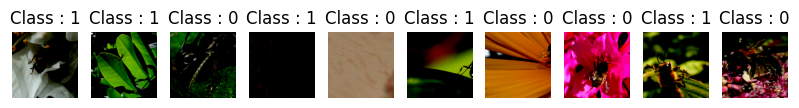

In [12]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i],(1,2,0)))
    plt.title("Class : " + str(y_train[i].item()))

In [13]:
''' 6. 불러온 특정 모델에 대해 학습을 진행하여 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTest Loss: {:.6f}".format(
                Epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()
            ))

In [14]:
''' 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [15]:
''' 8. 파이토치 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정하기 '''
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
''' 9. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
''' 10. 미리 학습되지 않은 ResNet18 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for Epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders['val'])
    print("\n[EPOCHS: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f}%\n".format(
        Epoch, test_loss, test_accuracy
    ))

Train Epoch: 1 [0/397 (0%)]	Test Loss: 0.710594
Train Epoch: 1 [160/397 (38%)]	Test Loss: 0.696844
Train Epoch: 1 [320/397 (77%)]	Test Loss: 0.706198

[EPOCHS: 1], 	Test Loss: 0.0228, 	Test Accuracy: 62.47%

Train Epoch: 2 [0/397 (0%)]	Test Loss: 0.662938
Train Epoch: 2 [160/397 (38%)]	Test Loss: 0.611410
Train Epoch: 2 [320/397 (77%)]	Test Loss: 0.665904

[EPOCHS: 2], 	Test Loss: 0.0211, 	Test Accuracy: 62.97%

Train Epoch: 3 [0/397 (0%)]	Test Loss: 0.613433
Train Epoch: 3 [160/397 (38%)]	Test Loss: 0.562401
Train Epoch: 3 [320/397 (77%)]	Test Loss: 0.681760

[EPOCHS: 3], 	Test Loss: 0.0208, 	Test Accuracy: 65.24%

Train Epoch: 4 [0/397 (0%)]	Test Loss: 0.598819
Train Epoch: 4 [160/397 (38%)]	Test Loss: 0.604951
Train Epoch: 4 [320/397 (77%)]	Test Loss: 0.710617

[EPOCHS: 4], 	Test Loss: 0.0223, 	Test Accuracy: 57.68%

Train Epoch: 5 [0/397 (0%)]	Test Loss: 0.613655
Train Epoch: 5 [160/397 (38%)]	Test Loss: 0.761863
Train Epoch: 5 [320/397 (77%)]	Test Loss: 0.633749

[EPOCHS: 5], 	Tes

In [19]:
''' 11. ImageNet 데이터로 미리 학습된 ResNet18 모델을 불러온 후 개미, 벌 이미지 데이터에 맞게 Fine-tuning '''
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders['val'])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f}%".format(
        epoch, valid_loss, valid_accuracy
    ))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 298MB/s]


Train Epoch: 10 [0/397 (0%)]	Test Loss: 0.952586
Train Epoch: 10 [160/397 (38%)]	Test Loss: 1.106733
Train Epoch: 10 [320/397 (77%)]	Test Loss: 0.792715

[EPOCH: 1], 	Test Loss: 0.0194, 	Test Accuracy: 68.77%
Train Epoch: 10 [0/397 (0%)]	Test Loss: 0.712170
Train Epoch: 10 [160/397 (38%)]	Test Loss: 0.547983
Train Epoch: 10 [320/397 (77%)]	Test Loss: 0.538691

[EPOCH: 2], 	Test Loss: 0.0159, 	Test Accuracy: 80.10%
Train Epoch: 10 [0/397 (0%)]	Test Loss: 0.482819
Train Epoch: 10 [160/397 (38%)]	Test Loss: 0.563279
Train Epoch: 10 [320/397 (77%)]	Test Loss: 0.538834

[EPOCH: 3], 	Test Loss: 0.0143, 	Test Accuracy: 82.87%
Train Epoch: 10 [0/397 (0%)]	Test Loss: 0.352116
Train Epoch: 10 [160/397 (38%)]	Test Loss: 0.444230
Train Epoch: 10 [320/397 (77%)]	Test Loss: 0.431022

[EPOCH: 4], 	Test Loss: 0.0120, 	Test Accuracy: 83.88%
Train Epoch: 10 [0/397 (0%)]	Test Loss: 0.435619
Train Epoch: 10 [160/397 (38%)]	Test Loss: 0.348942
Train Epoch: 10 [320/397 (77%)]	Test Loss: 0.315743

[EPOCH: 5]